In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np

In [2]:
from src.models import model

In [3]:
device = "cuda"

In [4]:
PINN = model.PINN_import("./results/2025-06-20_12-10-40/model_intermediate_model.pth", input_len=256, output_len=4, data_input=4, RFF = True, device = device)

In [5]:
datafile = "./data/periodic_data_cleaned.csv"

In [6]:
df = pd.read_csv(datafile)

In [7]:
df.describe()

,Time,point_id,Points:0,Points:1,Points:2,p,U:0,U:1,U:2
count,7.704929e+07,7.704929e+07,7.704929e+07,7.704929e+07,7.704929e+07,7.704929e+07,7.704929e+07,7.704929e+07,7.704929e+07
mean,2.500000e+03,7.689500e+04,2.000000e+00,1.000000e+00,1.000000e+00,1.590331e-05,3.081454e-01,-6.297386e-06,-1.241456e-04
std,1.446260e+03,4.439564e+04,1.183216e+00,7.831043e-01,5.962848e-01,6.356747e-04,1.443003e-01,6.359226e-03,1.031086e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.385121e-03,-8.813336e-03,-1.204620e-01,-1.552387e-01
25%,1.250000e+03,3.844700e+04,1.000000e+00,1.629123e-01,4.666667e-01,-9.548649e-05,2.039667e-01,-6.542691e-04,-1.708895e-03
50%,2.500000e+03,7.689500e+04,2.000000e+00,1.000000e+00,1.000000e+00,-1.415304e-09,3.637780e-01,0.000000e+00,0.000000e+00
75%,3.750000e+03,1.153430e+05,3.000000e+00,1.837088e+00,1.533333e+00,1.319332e-04,4.216372e-01,6.422824e-04,1.228451e-03
max,5.000000e+03,1.537900e+05,4.000000e+00,2.000000e+00,2.000000e+00,1.199402e-02,5.526472e-01,1.126035e-01,1.541705e-01


In [79]:
horizon = df.loc[np.abs(df["Points:0"])==0.].reset_index()
horizon = horizon[horizon["Points:2"]==0.]

In [80]:
time = np.random.randint(1, 150)
time = 196

In [81]:
horizon = horizon[horizon["Time"]==time*10]

In [82]:
horizon = horizon[horizon["Points:1"]>1.5]

In [83]:
horizon.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, 407011 to 407058
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     48 non-null     int64  
 1   Time      48 non-null     float64
 2   point_id  48 non-null     int64  
 3   Points:0  48 non-null     float64
 4   Points:1  48 non-null     float64
 5   Points:2  48 non-null     float64
 6   p         48 non-null     float64
 7   U:0       48 non-null     float64
 8   U:1       48 non-null     float64
 9   U:2       48 non-null     float64
dtypes: float64(8), int64(2)
memory usage: 4.1 KB


In [84]:
y_axis = horizon["Points:1"].values
u_x = horizon["U:0"].values
x_axis = horizon["Points:0"].values
abs_x_axis = np.abs(x_axis)

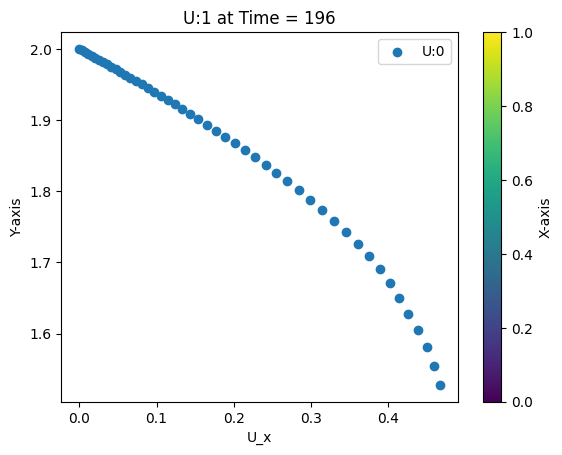

In [85]:
plt.scatter(u_x, y_axis, label="U:0")
plt.xlabel("U_x")
plt.ylabel("Y-axis")
plt.title("U:1 at Time = {}".format(time))
plt.legend()
plt.colorbar(label="X-axis")
plt.show()

In [86]:
import src.tools.util_func as util_func

In [87]:
forward_transform_input, forward_transform_output, inverse_transform_input, inverse_transform_output, Re = util_func.get_ND_non_dim(datafile, df, 2e-5)

Using dynamic pressure for non-dimensionalization.
Non-dimensionalization parameters:
Length scale (L): 1.4981540441513062
Velocity scale (U_hat): 0.2762989103794098
Time scale (T_hat): 5.422222137451172
Pressure scale (p_hat): 0.07634108787684912
Reynolds number (Re): 20696.917176246643


In [95]:
Y_range = torch.linspace(1.5, 2., 100)
## give me a tensor of (0., Y_range, time) knowing that Y_range is a tensor of shape (100,)
X_axis = 0. * torch.ones((Y_range.shape[0]))
Z_axis = 0. * torch.ones((Y_range.shape[0]))
time_axis = time * 10  * torch.ones((Y_range.shape[0]))

input_tensor = torch.stack((time_axis, X_axis, Y_range, Z_axis), dim=1)
input_tensor_np = input_tensor.numpy()
input_tensor_np = forward_transform_input(input_tensor)
input_tensor = torch.tensor(input_tensor_np, dtype=torch.float32)
input_tensor = input_tensor.to(device)

In [96]:
PINN = PINN.to(device)

In [97]:
U_x_pred = PINN(input_tensor)

In [98]:
inverse_transform_input(input_tensor_np)

array([[1.9600000e+03, 0.0000000e+00, 1.5000000e+00, 0.0000000e+00],
       [1.9600000e+03, 0.0000000e+00, 1.5050505e+00, 0.0000000e+00],
       [1.9600000e+03, 0.0000000e+00, 1.5101010e+00, 0.0000000e+00],
       [1.9600000e+03, 0.0000000e+00, 1.5151515e+00, 0.0000000e+00],
       [1.9600000e+03, 0.0000000e+00, 1.5202020e+00, 0.0000000e+00],
       [1.9600000e+03, 0.0000000e+00, 1.5252526e+00, 0.0000000e+00],
       [1.9600000e+03, 0.0000000e+00, 1.5303030e+00, 0.0000000e+00],
       [1.9600000e+03, 0.0000000e+00, 1.5353535e+00, 0.0000000e+00],
       [1.9600000e+03, 0.0000000e+00, 1.5404041e+00, 0.0000000e+00],
       [1.9600000e+03, 0.0000000e+00, 1.5454545e+00, 0.0000000e+00],
       [1.9600000e+03, 0.0000000e+00, 1.5505050e+00, 0.0000000e+00],
       [1.9600000e+03, 0.0000000e+00, 1.5555556e+00, 0.0000000e+00],
       [1.9600000e+03, 0.0000000e+00, 1.5606060e+00, 0.0000000e+00],
       [1.9600000e+03, 0.0000000e+00, 1.5656565e+00, 0.0000000e+00],
       [1.9600000e+03, 0.0000000e+

In [99]:
y_axis = inverse_transform_input(input_tensor_np)[:, 2]
u_x_pred = inverse_transform_output(U_x_pred.cpu().detach().numpy())
u_x_axis = u_x_pred[:, 0]
print(u_x_axis)

[0.21560302 0.21538058 0.21515092 0.2149203  0.21468204 0.21443416
 0.21418466 0.21392351 0.21365941 0.21338753 0.21310584 0.21282057
 0.21252824 0.2122214  0.2119111  0.21159473 0.21126448 0.21092902
 0.21058722 0.21022986 0.20986886 0.20949903 0.20911846 0.20872951
 0.20833248 0.20792545 0.2075095  0.20708741 0.20665249 0.20620966
 0.20575966 0.20529974 0.20483178 0.20435651 0.20387094 0.20337604
 0.20287666 0.20236878 0.20184843 0.20132606 0.20079164 0.20025167
 0.19970654 0.19915234 0.19859315 0.19802788 0.19745274 0.19687313
 0.19629031 0.1956995  0.1951064  0.19450794 0.19390018 0.1932954
 0.19268164 0.19206481 0.1914456  0.19082405 0.19019744 0.18957131
 0.18894112 0.18830828 0.18767574 0.1870416  0.18640633 0.18577309
 0.1851386  0.18450186 0.18386969 0.18323593 0.1826019  0.1819738
 0.18134725 0.18071826 0.1800995  0.17947614 0.17886136 0.17824927
 0.17764038 0.17703608 0.17643747 0.1758423  0.17525069 0.174668
 0.17408739 0.1735141  0.17294849 0.17238745 0.17183304 0.17128398

/tmp/ipykernel_2431227/375499761.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


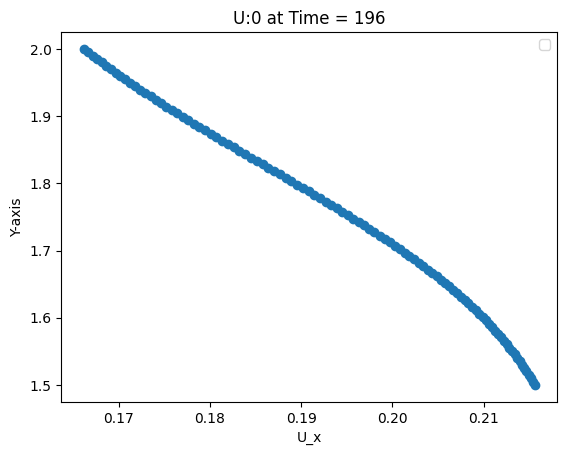

In [100]:
plt.scatter(u_x_axis, Y_range,)
plt.xlabel("U_x")
plt.ylabel("Y-axis")
plt.title("U:0 at Time = {}".format(time))
plt.legend()
plt.show()

/tmp/ipykernel_2431227/3330441034.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


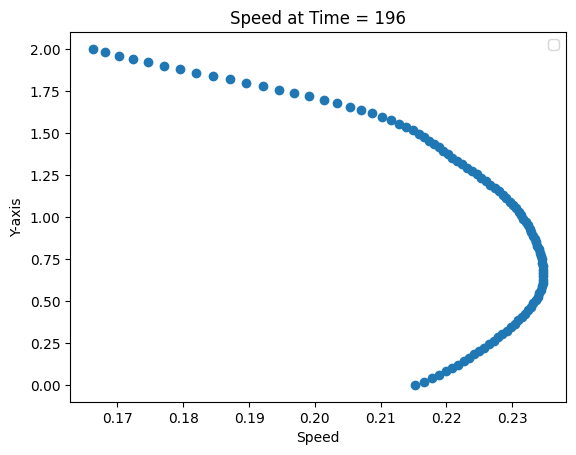

In [94]:
speed_pred = np.sqrt(np.sum(u_x_pred**2, axis=1))
plt.scatter(speed_pred, Y_range)
plt.xlabel("Speed")
plt.ylabel("Y-axis")
plt.title("Speed at Time = {}".format(time))
plt.legend()
plt.show()

In [73]:
horizon_input = horizon[["Time", "Points:0", "Points:1", "Points:2"]].values
horizon_input = forward_transform_input(horizon_input)
horizon_input = torch.tensor(horizon_input, dtype=torch.float32)
horizon_input = horizon_input.to(device)

horizon_output = horizon[["U:0", "U:1", "U:2", "p"]].values
horizon_output = forward_transform_output(horizon_output)
horizon_output = torch.tensor(horizon_output, dtype=torch.float32)
horizon_output = horizon_output.to(device)

In [74]:
pred_horizon_output = PINN(horizon_input)

In [76]:
nn.MSELoss()(pred_horizon_output, horizon_output).item()

0.7522131204605103

## Diagnonize

In [77]:
def get_horizon(time):
    horizon = df.loc[np.abs(df["Points:0"])==0.].reset_index()
    horizon = horizon[horizon["Points:2"]==0.]
    horizon = horizon[horizon["Time"]==time*10]
    horizon = horizon[horizon["Points:1"]>1.5]
    return horizon

In [78]:
for i in range(1, 200):
    horizon = get_horizon(i)
    if len(horizon) == 0:
        continue
    horizon_input = horizon[["Time", "Points:0", "Points:1", "Points:2"]].values
    horizon_input = forward_transform_input(horizon_input)
    horizon_input = torch.tensor(horizon_input, dtype=torch.float32)
    horizon_input = horizon_input.to(device)

    horizon_output = horizon[["U:0", "U:1", "U:2", "p"]].values
    horizon_output = forward_transform_output(horizon_output)
    horizon_output = torch.tensor(horizon_output, dtype=torch.float32)
    horizon_output = horizon_output.to(device)

    pred_horizon_output = PINN(horizon_input)

    print("Time: {}, MSE: {}".format(i, nn.MSELoss()(pred_horizon_output, horizon_output).item()))

Time: 1, MSE: 0.3719193935394287
Time: 2, MSE: 0.06398036330938339
Time: 3, MSE: 0.4518444538116455
Time: 4, MSE: 0.5663386583328247
Time: 5, MSE: 0.29521018266677856
Time: 6, MSE: 0.8264047503471375
Time: 7, MSE: 0.2096952497959137
Time: 8, MSE: 0.8154109716415405
Time: 9, MSE: 0.4472181499004364
Time: 10, MSE: 0.7284237742424011
Time: 11, MSE: 0.15478496253490448
Time: 12, MSE: 0.25620269775390625
Time: 13, MSE: 0.10514488816261292
Time: 14, MSE: 0.15103629231452942
Time: 15, MSE: 0.14955833554267883
Time: 16, MSE: 0.11642026156187057
Time: 17, MSE: 0.4427422881126404
Time: 18, MSE: 0.22057747840881348
Time: 19, MSE: 0.13471972942352295
Time: 20, MSE: 0.09700414538383484
Time: 21, MSE: 1.1750962734222412
Time: 22, MSE: 0.0966901034116745
Time: 23, MSE: 0.8365254402160645
Time: 24, MSE: 0.11743541061878204
Time: 25, MSE: 0.13846860826015472
Time: 26, MSE: 0.6246578693389893
Time: 27, MSE: 0.06348036974668503
Time: 28, MSE: 0.9777171015739441
Time: 29, MSE: 0.3985922336578369
Time: 30,

## Annex stuff

In [ ]:
from src.data_process.load_data import import_data
import src.tools.plot_tools as plot_tools

In [ ]:
x, y = import_data(datafile, df, forward_transform_input, forward_transform_output)

In [ ]:
t, _, _, _ = forward_transform_input(np.array([time, 1., 0., 1.]))

In [ ]:
t

In [ ]:
x[:, 0]

In [ ]:
indx = torch.where(torch.abs(x[:, 0] - t) < 0.5)
x_time = x[indx]
y_time = y[indx]

In [ ]:
x_time[:, 0].unique()

In [ ]:
pred_all = PINN(x_time.to(device))
mse = nn.MSELoss()
loss = mse(pred_all, y_time.to(device))
print("MSE Loss: ", loss.item())

In [ ]:
x_min, x_max = 0., 4.
y_min, y_max = 0., 2.
x_ax = np.linspace(x_min, x_max, 100)  # Spatial grid (x)
y_ax = np.linspace(y_min, y_max, 100)  # Spatial grid (y)
t = np.linspace(0, 100, 100)   # Time grid

# Create meshgrid for plotting
X, Y = np.meshgrid(x_ax, y_ax)

In [ ]:
sampled_z = np.unique(x[:, 3])
sampled_z = sampled_z[0]

In [ ]:
plot_tools.plot_speed_map(
        model=PINN,
        X=X,
        Y=Y,
        t=t,
        save_dir="",
        device=device,
        non_dim=True,
        forward_transform_input=forward_transform_input,
        inverse_transform_output=inverse_transform_output,
        additional_name="_intermediate_model",
        sample_z=sampled_z,
    )